Make depth profiles of ocean velocities in all 10 runs, plus composites. 

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import Functions_load_output as flo
import Functions_data_analysis as fda
import Functions_plotting as fp
from Datasets import exp_set_dict_warm_order
import xarray as xr

In [11]:
import importlib
importlib.reload(fda)

<module 'Functions_data_analysis' from '/glade/campaign/univ/ulnl0002/Gemma/Analysis/Functions_data_analysis.py'>

In [24]:
exp_set = 'ic_2001'#e.g., ic_1995, control
region = 'ET_2'
# region = 'lat_5'

# get 5 yrs for sensitivity exps
month_start_idx = 0
n_months = 60

# for ctrl run
# month_start_idx = 0
# n_months = 312 #for full control run

ic_str = exp_set.split('_')[-1]

Error with plotting highlight_locs!
here


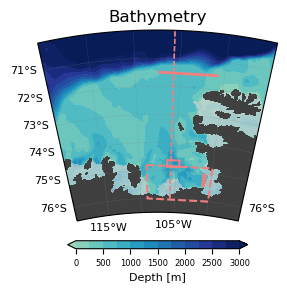

In [28]:
bathy_map = fp.plot_bathymetry_and_locs('bathy_map', [region,'shelf_box','EOT','PITT','PIG','ET_2','inner_shelf_corner'])
plt.savefig('Plots/Figure_bathymetry_map_with_locs.png',dpi=400)

In [29]:
# Ocean S, T, U, and V
prefix = 'state_3d_set2' # To plot ocean T, U, or V at a given depth
runs = exp_set_dict_warm_order[exp_set]
print(runs)
save_new_ens_da = True 

vars = ['S','T','U','V'] # all analyses follow this order
all_run_da_list = []
for var in vars:
    fname = 'Saved Arrays/Ensemble_data/'+var+'_'+exp_set+'_'+region+'.nc'
    try:
        all_run_da = xr.open_dataset(fname)[var]
        print(fname,'found')
    except:
        print('loading new data array for',var)
        all_run_da = fda.get_ensemble_data_for_ic(var, runs, region, prefix, month_start_idx = month_start_idx, n_months=n_months)
        if save_new_ens_da:
            all_run_ds = xr.Dataset({var: all_run_da})
            all_run_ds.to_netcdf(fname)
            # all_run_da.to_netcdf(fname,'w',data_vars={var:all_run_da.name})
            print('Saved as',fname)
    
    # these have shape (10, 12, 70, 256 lats)
    all_run_da_list.append(all_run_da)

print('Data retrieved!')

['run_forc_erai_1982_rep_ic_2001', 'run_forc_erai_1984_rep_ic_2001', 'run_forc_erai_1989_rep_ic_2001', 'run_forc_erai_1992_rep_ic_2001', 'run_forc_erai_1994_rep_ic_2001', 'run_forc_erai_2003_rep_ic_2001', 'run_forc_erai_2009_rep_ic_2001', 'run_forc_erai_1991_rep_ic_2001', 'run_forc_erai_2015_rep_ic_2001', 'run_forc_erai_2011_rep_ic_2001']
Saved Arrays/Profile_ens_nc/ET_2_ic_2001_S.nc found
Saved Arrays/Profile_ens_nc/ET_2_ic_2001_T.nc found
Saved Arrays/Profile_ens_nc/ET_2_ic_2001_U.nc found
Saved Arrays/Profile_ens_nc/ET_2_ic_2001_V.nc found
Data retrieved!


In [30]:
# Calculate annual avgs, ens mean for each yr, and calculate warm/cool composites in anomalies

#order (S,T,U,V). each item has shape (5 yrs, lons, lats)
ens_mean_list = [] 
warm_list = []
warm_anom_list = [] 
cool_list = []
cool_anom_list = []

for i in range(len(vars)):

    # Load variable data: (10 runs, 60 times, lons, lats) 
    var_i_data = all_run_da_list[i]

    # avg over time for each yr: (10, 60, lons, lats) -> (10, 5, lons, lats)
    var_all_run_ann_mean = var_i_data.resample(time='12M').mean(dim='time')

    # calculate ens means of annual avgs: (10, 5, lons, lats) -> (5 yrs, lons, lats)
    var_ens_mean = var_all_run_ann_mean.mean(dim='run')
    ens_mean_list.append(var_ens_mean)

    # calculate composites: (10 runs, 5 yrs, lons, lats) -> (5 yrs, lons, lats)
    var_warm_comp_runs = var_all_run_ann_mean.isel(run = slice(0,4))
    var_warm_comp = var_warm_comp_runs.mean(dim='run')
    var_cool_comp_runs = var_all_run_ann_mean.isel(run = slice(4,8))
    var_cool_comp = var_cool_comp_runs.mean(dim='run')
    warm_list.append(var_warm_comp)
    cool_list.append(var_cool_comp)
    if i == 0:
        print('Warm composite runs:',var_warm_comp_runs.run.values)
        print('Cool composite runs:',var_cool_comp_runs.run.values)

    # Put composites in anomalies: (5 yrs, lons, lats)
    var_warm_anom = var_warm_comp - var_ens_mean
    var_cool_anom = var_cool_comp - var_ens_mean

    warm_anom_list.append(var_warm_anom)
    cool_anom_list.append(var_cool_anom)


Warm composite runs: ['run_forc_erai_1982_rep_ic_2001' 'run_forc_erai_1984_rep_ic_2001'
 'run_forc_erai_1989_rep_ic_2001' 'run_forc_erai_1992_rep_ic_2001']
Cool composite runs: ['run_forc_erai_1994_rep_ic_2001' 'run_forc_erai_2003_rep_ic_2001'
 'run_forc_erai_2009_rep_ic_2001' 'run_forc_erai_1991_rep_ic_2001']


In [31]:
cmap_dict = {'U':'BrBG_r','V':'PiYG_r','T':'RdBu_r','S':'GnBu'}


lev_dict = {'U':np.linspace(-0.1,0.1,11),'V':np.linspace(-0.1,0.1,11),\
           'T':np.linspace(-0.5,0.5,5),'S':np.arange(34.2,35,0.1)}

anom_lev_dict = {'U':np.linspace(-0.04,0.04,9),'V':np.linspace(-0.04,0.04,9),\
                 'T':np.linspace(-0.3,.3,5),'S':np.arange(-0.1,0.2,0.05)}

xlims_dict = {'ET':[-75.8,-70.5],'lat':[-110.2,-98]}
xlims = xlims_dict[region.split('_')[0]]

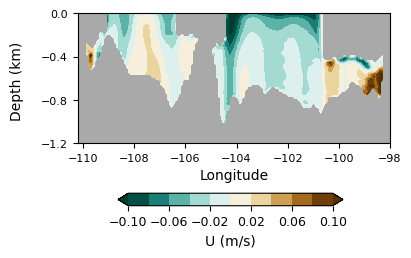

In [15]:
# Plot ensemble mean time avged U
importlib.reload(fp)

# fig_name='Plots/Figure_U_5thyr_mean_depth_'+x_ax+'_profile_ens_mean_'+exp_set+'.png'
fig_name=None

n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height= 1,1,4,2.5,0.45,0.3,.2,.05
plot_format = [n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height]

fp.make_side_profile_figs([ens_mean_list[2].mean(dim='time')], 'U',plot_format,
                          levs=lev_dict['U'],
                          subplot_labels = [''],cmap=cmap_dict['U'], 
                          ylims=[-1.2,0],xlims=xlims,fig_name = fig_name)

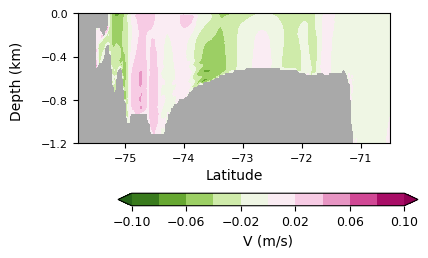

In [33]:
# Plot ensemble mean time avged V
importlib.reload(fp)

# fig_name='Plots/Figure_V_5thyr_mean_depth_'+x_ax+'_profile_ens_mean_'+exp_set+'.png'
fig_name=None

n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height= 1,1,4,2.5,0.45,0.3,.2,.05
plot_format = [n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height]

fp.make_side_profile_figs([ens_mean_list[3].mean(dim='time')], 'V',plot_format,
                          levs=lev_dict['V'],
                          subplot_labels = [''],cmap=cmap_dict['V'], 
                          ylims=[-1.2,0],xlims=xlims,fig_name = fig_name)

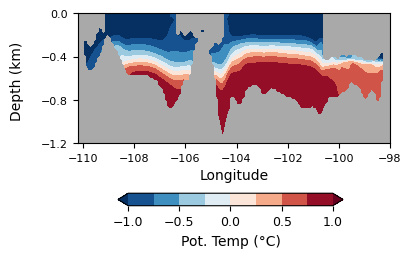

In [16]:
# Plot ensemble mean time avged T
importlib.reload(fp)

# fig_name='Plots/Figure_U_5thyr_mean_depth_'+x_ax+'_profile_ens_mean_'+exp_set+'.png'
fig_name=None

n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height= 1,1,4,2.5,0.45,0.3,.2,.05
plot_format = [n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height]

fp.make_side_profile_figs([ens_mean_list[1].mean(dim='time')], 'T',plot_format,
                          levs=np.linspace(-1,1,9),subplot_labels = [''],cmap=cmap_dict['T'], 
                          ylims=[-1.2,0],xlims=xlims,
                          fig_name = fig_name)

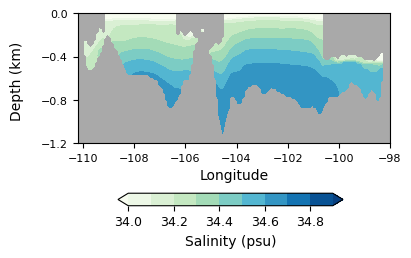

In [17]:
# Plot ensemble mean time avged S
importlib.reload(fp)

# fig_name='Plots/Figure_U_5thyr_mean_depth_'+x_ax+'_profile_ens_mean_'+exp_set+'.png'
fig_name=None

n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height= 1,1,4,2.5,0.45,0.3,.2,.05
plot_format = [n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height]

fp.make_side_profile_figs([ens_mean_list[0].mean(dim='time')], 'S',plot_format,
                          levs=np.arange(34,35,0.1),subplot_labels = [''],cmap=cmap_dict['S'], 
                          ylims=[-1.2,0],xlims=xlims,
                          fig_name = fig_name)

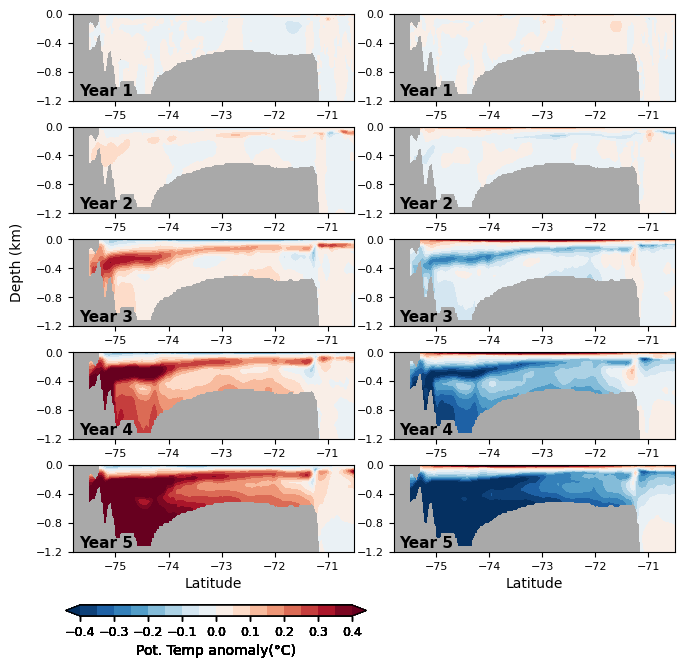

In [32]:
importlib.reload(fp)

# Plot T colors 

# Edit fig name for saving!!
# fig_name = 'Plots/Figure_U_comp_all_yrs_'+region+'_'+exp_set+'.png'
fig_name = None

n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height = 6,2,7,7,.01,.11,.08,0.015
plot_format = [n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height]

plot_t_anom = []
plot_t = []
for i in range(5):
    plot_t_anom.append(warm_anom_list[1][i])
    plot_t_anom.append(cool_anom_list[1][i])
    plot_t.append(warm_list[1][i])
    plot_t.append(cool_list[1][i])
    
sp_labs =   [f'Year {year}' for year in range(1, 6) for _ in range(2)]

fp.make_side_profile_figs(plot_t_anom, 'T anomaly',plot_format,
                          levs=np.arange(-0.4,.45,0.05),\
                          subplot_labels = sp_labs,cmap=cmap_dict['T'], \
                          ylims=[-1.2,0],xlims=xlims,\
                          fig_name = fig_name)

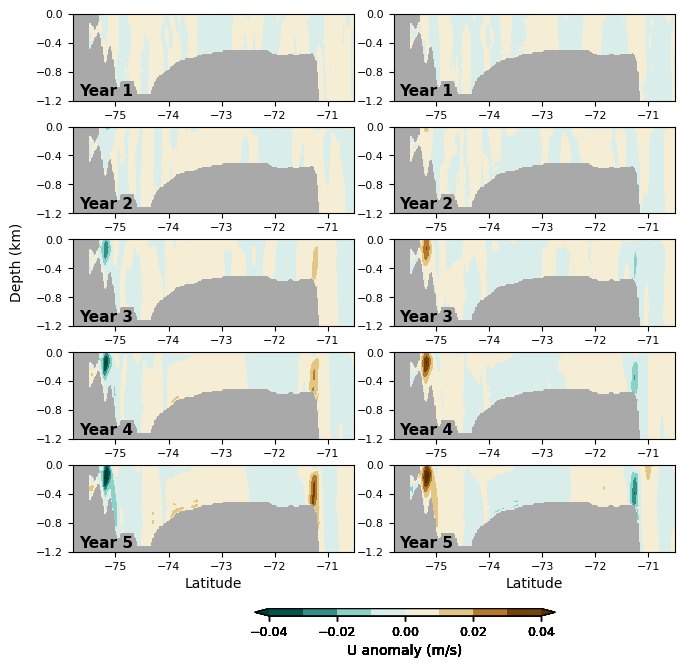

In [34]:
importlib.reload(fp)

# Plot U with T contours

# Edit fig name for saving!!
# fig_name = 'Plots/Figure_U_comp_all_yrs_'+region+'_'+exp_set+'.png'
fig_name = None
plot_T_anom= True

n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height = 6,2,7,7,.01,.38,.08,0.01
plot_format = [n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height]

plot_u_anom = []
plot_t_anom = []
plot_t = []
for i in range(5):
    plot_u_anom.append(warm_anom_list[2][i])
    plot_u_anom.append(cool_anom_list[2][i])
    plot_t_anom.append(warm_anom_list[1][i])
    plot_t_anom.append(cool_anom_list[1][i])
    plot_t.append(warm_list[1][i])
    plot_t.append(cool_list[1][i])
    
sp_labs =   [f'Year {year}' for year in range(1, 6) for _ in range(2)]

fp.make_side_profile_figs(plot_u_anom, 'U anomaly',plot_format,
                          levs=anom_lev_dict['U'],\
                          subplot_labels = sp_labs,cmap=cmap_dict['U'], \
                          ylims=[-1.2,0],xlims=xlims,\
                          fig_name = fig_name)

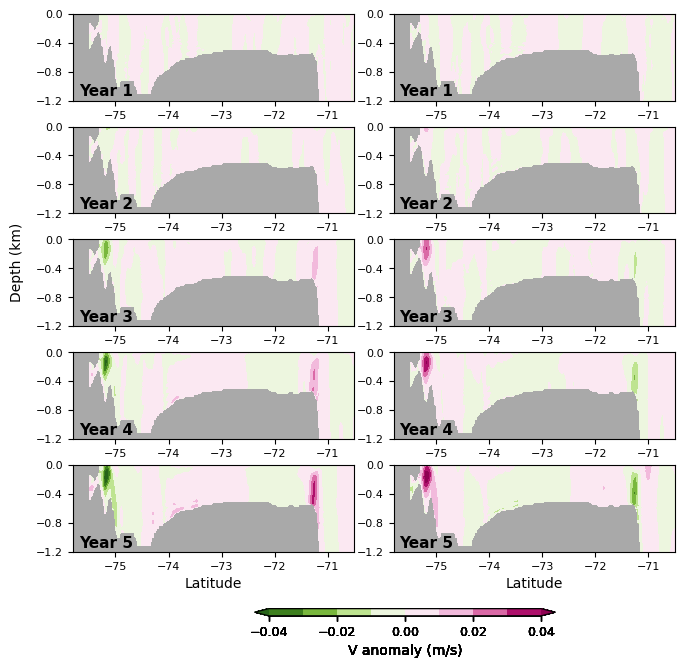

In [36]:
importlib.reload(fp)

# Plot V 

# Edit fig name for saving!!
# fig_name = 'Plots/Figure_V_comp_all_yrs_'+region+'_'+exp_set+'.png'
fig_name = None
plot_T_anom= True

n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height = 6,2,7,7,.01,.38,.08,0.01
plot_format = [n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height]

plot_v_anom = []
plot_t_anom = []
plot_t = []
for i in range(5):
    plot_v_anom.append(warm_anom_list[2][i])
    plot_v_anom.append(cool_anom_list[2][i])
    plot_t_anom.append(warm_anom_list[1][i])
    plot_t_anom.append(cool_anom_list[1][i])
    plot_t.append(warm_list[1][i])
    plot_t.append(cool_list[1][i])
    
sp_labs =   [f'Year {year}' for year in range(1, 6) for _ in range(2)]

fp.make_side_profile_figs(plot_v_anom, 'vV anomaly',plot_format,
                          levs=anom_lev_dict['V'],\
                          subplot_labels = sp_labs,cmap=cmap_dict['V'], \
                          ylims=[-1.2,0],xlims=xlims,\
                          fig_name = fig_name)

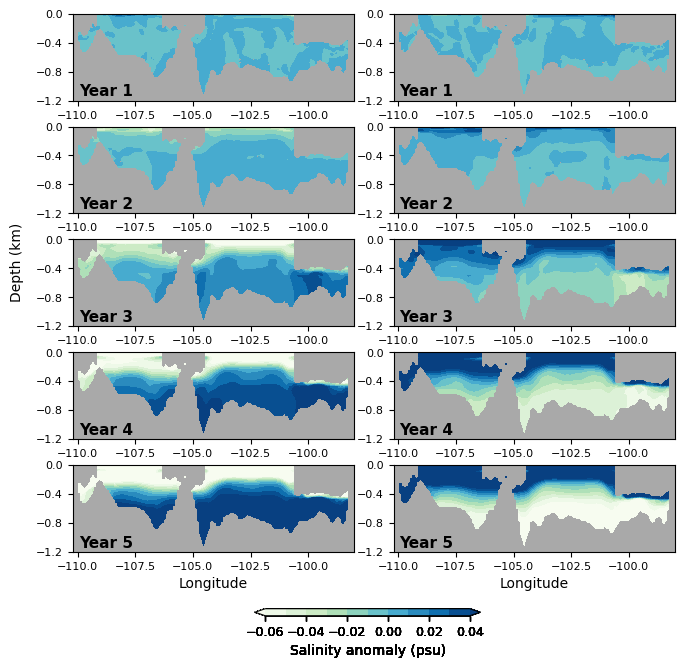

In [84]:
importlib.reload(fp)

# Plot S

# Edit fig name for saving!!
# fig_name = 'Plots/Figure_U_comp_all_yrs_'+region+'_'+exp_set+'.png'
fig_name = None

n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height = 6,2,7,7,.01,.38,.08,0.01
plot_format = [n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height]

plot_s_anom = []
plot_s = []
for i in range(5):
    plot_s_anom.append(warm_anom_list[0][i])
    plot_s_anom.append(cool_anom_list[0][i])
    plot_s.append(warm_list[0][i])
    plot_s.append(cool_list[0][i])
    
sp_labs =   [f'Year {year}' for year in range(1, 6) for _ in range(2)]

fp.make_side_profile_figs(plot_s_anom, 'S anomaly',plot_format,
                          levs=np.arange(-0.06,0.05,0.01),\
                          subplot_labels = sp_labs,cmap=cmap_dict['S'], \
                          ylims=[-1.2,0],xlims=xlims,\
                          fig_name = fig_name)

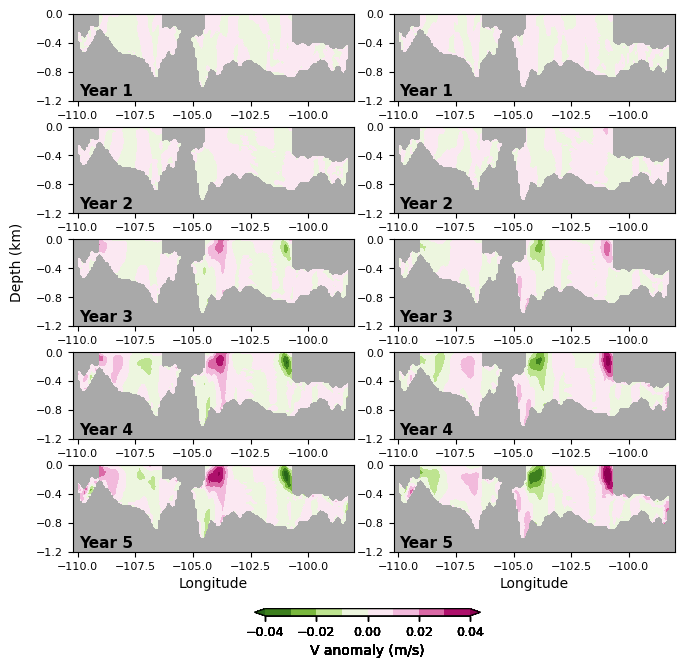

In [89]:
importlib.reload(fp)

# Plot V

# Edit fig name for saving!!
# fig_name = 'Plots/Figure_U_comp_all_yrs_'+region+'_'+exp_set+'.png'
fig_name = None
plot_T_anom= True

n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height = 6,2,7,7,.01,.38,.08,0.01
plot_format = [n_rows,n_cols,width,height,bot_pos,cb_x_pos,cb_y_pos,cb_height]

plot_v_anom = []
for i in range(5):
    plot_v_anom.append(warm_anom_list[3][i])
    plot_v_anom.append(cool_anom_list[3][i])
    
sp_labs =   [f'Year {year}' for year in range(1, 6) for _ in range(2)]

fp.make_side_profile_figs(plot_v_anom, 'V anomaly',plot_format,
                          levs=anom_lev_dict['V'],\
                          subplot_labels = sp_labs,cmap=cmap_dict['V'], \
                          ylims=[-1.2,0],xlims=xlims,\
                          fig_name = fig_name)